In [1]:
from coffea import processor
import argparse
from coffea import util
from coffea.nanoevents import BaseSchema , NanoEventsFactory
import awkward as ak
import numba
import json
import rich
import numpy as np
import os
import shutil
import logging
from processor_mHrecoil import mHrecoil
from coffea.dataset_tools import apply_to_fileset,max_chunks,preprocess
import dask
import dask_awkward as dak

In [3]:
def getraw(jsonfilename):
    '''
    Load the raw dictionary
    '''
    with open(jsonfilename) as f :
        full_fileset = json.load(f)
    return full_fileset

def add_redirector(filesetname,redirector=""):
    '''
    Choose your redirector
    '''
    redirectors = {
        "eos":'root://eospublic.cern.ch/'
    }
    if len(redirector) != 0 :
        redirector_string = redirectors[redirector]
    else :
        redirector_string = ''
    
    raw_fileset = getraw(filesetname)

    # Expecting raw_fileset to be in {key1:{files:{filepath1:events, filepath2:events, ...}},key2:... } format
    new_fileset = {}
    for key in raw_fileset.keys():
        new_files = {}
        new_fileset[key] = {}
        for file_path in raw_fileset[key]["files"].keys():
            new_name = redirector_string+file_path
            new_files[new_name] = "events"
        new_fileset[key]["files"] = new_files

    return new_fileset

myfileset = add_redirector(filesetname="./local_fileset.json")
myfileset

{'p8_ee_ZZ_ecm240': {'files': {'data/p8_ee_ZH_ecm240/events_101027117.root': 'events',
   'data/p8_ee_ZH_ecm240/events_101027117_a.root': 'events',
   'data/p8_ee_ZH_ecm240/events_101027117_b.root': 'events',
   'data/p8_ee_ZH_ecm240/events_101027117_c.root': 'events',
   'data/p8_ee_ZH_ecm240/events_101027117_d.root': 'events',
   'data/p8_ee_ZH_ecm240/events_101027117_e.root': 'events',
   'data/p8_ee_ZH_ecm240/events_101027117_f.root': 'events'}}}

In [3]:
executor = "dask"
chunk_size = 100000
maxchunks = 10

In [4]:
myfileset = getraw('./local_fileset.json')

dataset_runnable, dataset_updated = preprocess(
    myfileset,
    align_clusters=False,
    step_size=100_000,
    files_per_batch=1,
    skip_bad_files=True,
    save_form=False,
)

In [5]:
to_compute = apply_to_fileset(
                mHrecoil(),
                max_chunks(dataset_runnable, maxchunks ),
                schemaclass=BaseSchema,
            )
(out,) = dask.compute(to_compute)
print(out)

{'p8_ee_ZZ_ecm240': {'histograms': {'Z_mass': Hist(Regular(100, 0, 150, label='Axis 0'), storage=Double()) # Sum: 3148.0, 'Recoil_mass': Hist(Regular(100, 60, 160, label='Axis 0'), storage=Double()) # Sum: 2682.0 (3148.0 with flow)}}}


In [6]:
#For futures execution
# if executor == "futures" :
#     futures_run = processor.Runner(
#         executor = processor.FuturesExecutor(workers=inputs.workers),
#         schema=BaseSchema,
#         chunksize= chunk_size ,
#         maxchunks= max_chunks,
#         xrootdtimeout=120
#     )
#     Output = futures_run(
#         fileset,
#         "Events",
#         processor_instance=mHrecoil()
#     )
    
# #For dask execution
# elif executor == "dask" :
#     raise('Dask execution is not available yet!')

# #For condor execution
# elif executor == "condor" :
#     raise('HTCondor execution is not available yet!')
    
#################################
# Create the output file #
#################################
print("Output produced")
Output = out


Output produced


In [7]:
output_file = f"mHrecoil_mumu.coffea"
print("Saving the output to : " , output_file)
path ="outputs/FCCee/higgs/mH-recoil/mumu/"
if not os.path.exists(path):
    os.makedirs(path)
util.save(output= Output, filename=path+output_file)
print(f"File {output_file} saved.")
print("Execution completed.")

Saving the output to :  mHrecoil_mumu.coffea
File mHrecoil_mumu.coffea saved.
Execution completed.


In [8]:
Z_mass = Output['p8_ee_ZZ_ecm240']['histograms']['Z_mass']
Recoil_mass = Output['p8_ee_ZZ_ecm240']['histograms']['Recoil_mass']

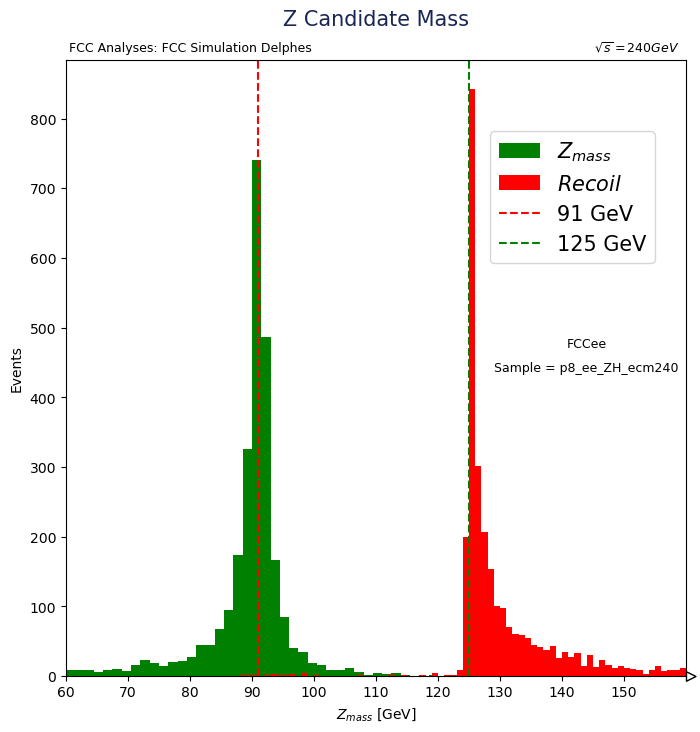

In [10]:
import hist
import matplotlib.pyplot as plt
import mplhep as hep
fig, ax = plt.subplots(figsize=(8,8))
hep.histplot(
    Z_mass,
    yerr=0,
    histtype='fill',
    label='$Z_{mass}$',
    color='g',
    ax=ax
)
hep.histplot(
    Recoil_mass,
    yerr=0,
    histtype='fill',
    label='$Recoil$',
    color='r',
    ax=ax
)
xlims = [60,160]
# plt.text("Preliminary",0,0)
ax.text(0.20, 1.02, 'FCC Analyses: FCC Simulation Delphes', fontsize=9, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.text(0.92, 1.02, '$\\sqrt{s} = 240GeV$', fontsize=9, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.text(0.84,0.54, 'FCCee', fontsize=9, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.text(0.84,0.50, 'Sample = p8_ee_ZH_ecm240', fontsize=9, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
ax.set_ylabel("Events")
ax.set_xlabel("$Z_{mass}$ [GeV]")
plt.xlim(xlims)
plt.xticks(np.arange(xlims[0],xlims[1],10))
ax.set_title(r"Z Candidate Mass",pad=25,  fontsize= "15", color="#192655")
ax.axvline(91,label="91 GeV", color='r', linestyle='--')
ax.axvline(125,label="125 GeV", color='g', linestyle='--')
fig.legend(prop={"size":15},loc= (0.70,0.64) )
plot_path = 'outputs/FCCee/higgs/mH-recoil/mumu/plots/'
if not os.path.exists(plot_path):
    os.makedirs(plot_path)
fig.savefig(plot_path+'Z_Peak_with_recoil.png',dpi=240);

In [4]:
from coffea.util import load

In [5]:
load("./outputs/FCCee/higgs/mH-recoil/mumu/mHrecoil_mumu.coffea")

{'p8_ee_ZZ_ecm240': {'histograms': {'Z_mass': Hist(Regular(100, 0, 150, label='Axis 0'), storage=Double()) # Sum: 3148.0,
   'Recoil_mass': Hist(Regular(100, 60, 160, label='Axis 0'), storage=Double()) # Sum: 2682.0 (3148.0 with flow)}}}

In [8]:
a = ak.Array([[1,2],[],[2]])
a

<Array [[1, 2], [], [2]] type='3 * var * int64'>

In [18]:
b = ak.num(a, axis = 0)
int(b)

3

In [20]:
c = dak.from_awkward(a,npartitions=int(b))

In [21]:
c.compute()

<Array [[1, 2], [], [2]] type='3 * var * int64'>

In [1]:
plot_props = {
    'Zm':{'name':'Zm','title':'Z Candidate mass','xlabel':'$Z_m$ GeV','ylabel':'Events','bins':100,'xmin':0,'xmax':250},
    'Zm_zoom':{'name':'Zm_zoom','title':'Z Candidate mass','xlabel':'$Z_m$ GeV','ylabel':'Events','bins':40,'xmin':80,'xmax':100},
    'Recoilm':{'name':'Recoilm','title':'Leptonic Recoil mass','xlabel':'$Recoil_m$ GeV','ylabel':'Events','bins':100,'xmin':0,'xmax':200},
    'Recoilm_zoom':{'name':'Recoilm_zoom','title':'Leptonic Recoil mass','xlabel':'$Recoil_m$ GeV','ylabel':'Events','bins':200,'xmin':80,'xmax':160},
    'Recoilm_zoom1':{'name':'Recoilm_zoom1','title':'Leptonic Recoil mass','xlabel':'$Recoil_m$ GeV','ylabel':'Events','bins':100,'xmin':120,'xmax':140},
    'Recoilm_zoom2':{'name':'Recoilm_zoom2','title':'Leptonic Recoil mass','xlabel':'$Recoil_m$ GeV','ylabel':'Events','bins':200,'xmin':120,'xmax':140},
    'Recoilm_zoom3':{'name':'Recoilm_zoom3','title':'Leptonic Recoil mass','xlabel':'$Recoil_m$ GeV','ylabel':'Events','bins':400,'xmin':120,'xmax':140},
    'Recoilm_zoom4':{'name':'Recoilm_zoom4','title':'Leptonic Recoil mass','xlabel':'$Recoil_m$ GeV','ylabel':'Events','bins':800,'xmin':120,'xmax':140},
    'Recoilm_zoom5':{'name':'Recoilm_zoom5','title':'Leptonic Recoil mass','xlabel':'$Recoil_m$ GeV','ylabel':'Events','bins':2000,'xmin':120,'xmax':140},
    'Recoilm_zoom6':{'name':'Recoilm_zoom6','title':'Leptonic Recoil mass','xlabel':'$Recoil_m$ GeV','ylabel':'Events','bins':100,'xmin':130.3,'xmax':140}
}

In [7]:
import awkward as ak
props = ak.Record(plot_props['Zm'])
props

<Record {name: 'Zm', title: ..., ...} type='{name: string, title: string, x...'>

In [10]:
import pandas as pd

In [12]:
df = pd.DataFrame(plot_props)

In [20]:
df['Zm'].title

'Z Candidate mass'

In [22]:
import numpy as np

In [32]:
xmin = 120
xmax = 140
x_ticks = 10
np.linspace(xmin,xmax,x_ticks+1)

array([120., 122., 124., 126., 128., 130., 132., 134., 136., 138., 140.])